<h1><bold>
Atelier 1: Systèmes de Recherche d'Images par le Contenu CBIR - Descripteurs globaux </bold>

----
<h2>1	Introduction</h2>

L’objectif de cet atelier est de vous initier aux systèmes de recherche basée sur le contenu visuel (CBIR, Content-Based Image Retrieval). Le CBIR permet de rechercher des images similaires à une image requête dans une base constituée d’images. Cette similarité n'est pas calculée sur les images elles-mêmes, mais par le biais d’une descripteur choisi par celui qui a conçu le système. La figure ci-dessous présente une vue globale d’un système CBIR.



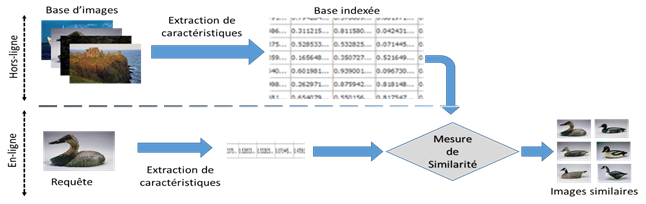

Un système CBIR est organisé en deux phases :


1.   Phase hors ligne, souvent appelée indexation, au cours de laquelle un vecteur descripteur est extrait pour chaque image et enregistré sous forme de base d'index.
2.   Phase en ligne, souvent appelée recherche, au cours de laquelle le système recherche les images similaires à une image requête. Le même type de descripteur est extrait de l'image requête et comparé à la base d'index.



Deux paramètres sont à prendre en considération lors de l’élaboration d’un système CBIR : les descripteurs (également appelés caractéristiques) à utiliser pour constituer la base d'index, et la mesure de similarité à utiliser pour rechercher les images les plus similaires à une image requête. Ainsi, la recherche se fait en mesurant la distance entre les descripteurs plutôt qu'entre les images.
<br>
<br>
Les descripteurs utilisés ici pour constituer la base d'index sont des descripteurs globaux de bas niveau, tels que : la forme, la couleur et la texture. La mesure de similarité utilisée peut être une simple distance euclidienne.

<h2>2	Base d’images</h2>
Pour cet atelier, nous allons utiliser une partie de la base d’images COREL. La base COREL contient 10 800 images classées en 80 groupes d’images. Cette base est parfaite pour comprendre les fondamentaux du CBIR. Ici, nous allons utiliser seulement 270 images appartenant à deux groupes d’images et qui sont regroupées dans un seul dossier.<br>
Le lien vers la base d'images est le suivant : https://drive.google.com/drive/folders/1_k42mYdBMdQVd8bx_A3c89mJxcTKELqT?usp=drive_link <br>
<br>
Téléchargez la base sur votre Google Drive.
Le chemin du dossier sur votre drive doit être:
"My Drive/CBIR_DataSet/obj_decoys/"

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from google.colab import drive

drive.mount('/content/drive')

path_base = '/content/drive/MyDrive/CBIR_DataSet/obj_decoys/'
path_requete = '/content/drive/MyDrive/CBIR_DataSet/img_requetes/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2>3	Implémentation</h2>

Pour la première étape, qui est l'indexation, le premier code à écrire consiste à parcourir toutes les images de la base de données afin d'extraire de chacune un vecteur descripteur approprié.

<h2>3.1	Lecture des images</h2>
1. Lire toutes les images de la base et afficher 6 images aléatoirement.<br>
2. Lire les deux images requête  qui se trouvent dans le dossier My Drive/CBIR_DataSet/img_requetes/

In [4]:
def lire_images(path):
    images = []
    noms = []
    for file in os.listdir(path):
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(path, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            noms.append(file)
    return images, noms

images_base, noms_base = lire_images(path_base)

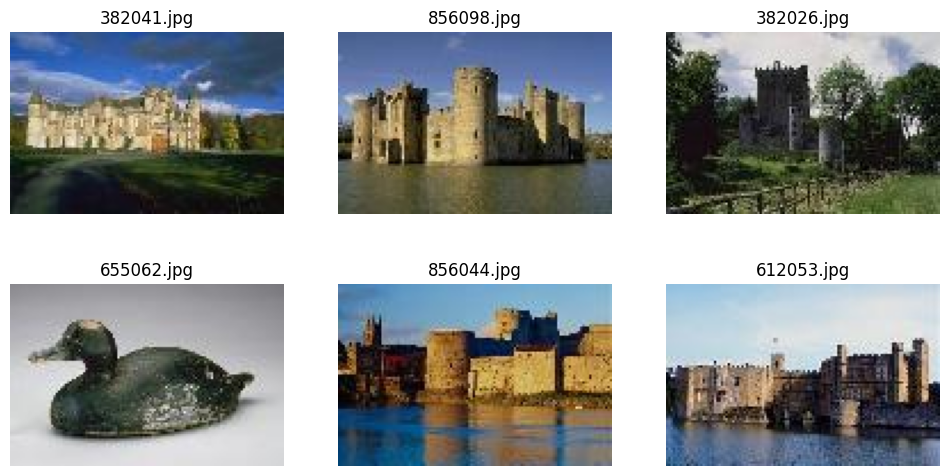

In [5]:
plt.figure(figsize=(12,6))
for i, idx in enumerate(random.sample(range(len(images_base)), 6)):
    plt.subplot(2,3,i+1)
    plt.imshow(images_base[idx])
    plt.title(noms_base[idx])
    plt.axis('off')
plt.show()

<h2>3.2	Recherche par image entière</h2>
Pour une première implémentation d’un système CBIR, l’objectif est d’afficher les 5 images les plus similaires à l’image requête « ImageRequete.jpg » en se basant sur un calcul de différence entre images entières.<br>
<br>
1. Utiliser la distance enclidienne entre l'image requête et toutes les images de la base. Les distances seront enregistrées dans un dictionnaire et seront par la suite triées par ordre croissant.<br>
2. Afficher l'image requête ainsi que les 5 images les plus similaires en termes de distance euclidienne. Interpréter les résultats.

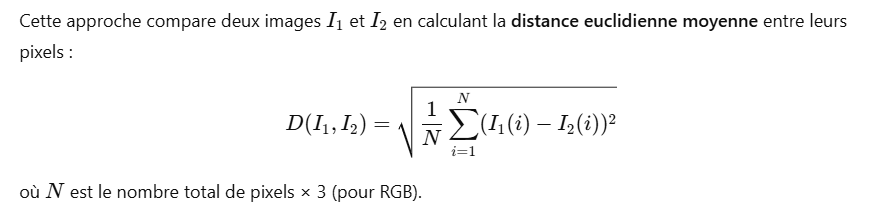

In [9]:
path_requete = '/content/drive/MyDrive/CBIR_DataSet/img_requetes/ImageRequete.jpg'
img_requete = cv2.imread(path_requete)
img_requete = cv2.cvtColor(img_requete, cv2.COLOR_BGR2RGB)

img_requete_resized = cv2.resize(img_requete, (128,128))
images_base_resized = [cv2.resize(img, (128,128)) for img in images_base]

In [10]:
def euclidean_distance(img1, img2):
    diff = img1.astype(np.float32) - img2.astype(np.float32)
    dist = np.sqrt(np.mean(np.square(diff)))
    return dist

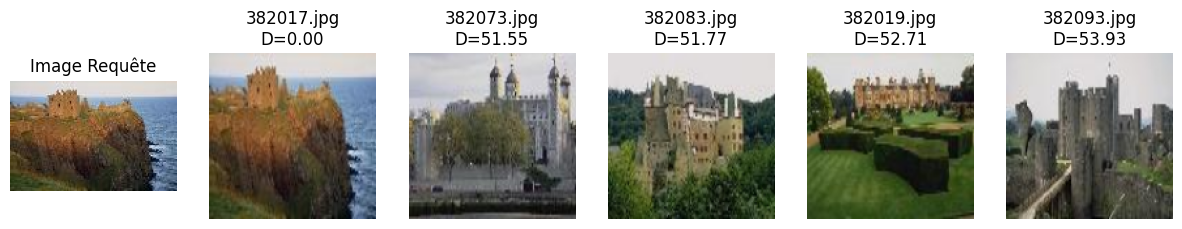

In [11]:
distances = {}
for i, img in enumerate(images_base_resized):
    distances[noms_base[i]] = euclidean_distance(img_requete_resized, img)

# Tri par distance croissante
sorted_results = sorted(distances.items(), key=lambda x: x[1])
top5 = sorted_results[:5]

# --- Affichage des résultats ---
plt.figure(figsize=(15,5))
plt.subplot(1,6,1)
plt.imshow(img_requete)
plt.title("Image Requête")
plt.axis('off')

for i, (name, dist) in enumerate(top5):
    plt.subplot(1,6,i+2)
    img = images_base_resized[noms_base.index(name)]
    plt.imshow(img)
    plt.title(f"{name}\nD={dist:.2f}")
    plt.axis('off')
plt.show()

### **Interprétation des résultats** (image entière)
Les 5 images affichées sont celles dont les valeurs de distance euclidienne sont les plus faibles.
Cependant, cette méthode ne tient pas compte de la structure (formes, textures) ni du positionnement spatial des objets.

<h2>3.3	Recherche par Couleur</h2>
Dans cette partie, la caractéristique couleur sera utilisée pour développer notre système CBIR. La recherche est effectuée par similarité entre les caractéristiques de l’image requête et celles de la base d’index.  Le vecteur descripteur couleur à utiliser est constitué des valeurs des moments statistiques : moyenne et variance de chaque composante couleur. La taille du vecteur sera donc de 6.
<br>
<br>
Le code doit permettre d'abord d’indexer la base d’images et ensuite de lancer la recherche pour une image requête et d’afficher les 5 images les plus similaires.<br>
Le code contiendra 2 parties : <br>
1. La partie d'indexation : la fonction « CBIR_Indexation » est appelée avec comme paramètre la taille du vecteur descripteur. Cette partie ne doit être exécutée qu'une seule fois.<br>
2. La partie de recherche : la fonction « CBIR_Recherche » est appelée avec comme paramètres l'image requête, la matrice des descripteurs et les noms des images correspondantes.<br>
<br>
Le vecteur descripteur est créé par la fonction « getFeatures », qui prend en argument l'image et la taille du vecteur. C'est cette fonction que nous allons modifier pour ajouter d'autres descripteurs par la suite. Cette fonction appelle ici la fonction « color_Moments » qui retourne les 6 moments de couleur.


In [28]:
# le système CBIR est constituée de 2 étapes; Indexation et Recherche
# On va créer une fonction pour l'indexation d'une image
# C'est l'équivalent d'extraire une vecteur descripteur en se basant sur les moments statistiques des couleurs
import numpy as np

def color_Moments(img):
  img = cv2.resize(img, (256, 256))
  moments = []
  for i in range(3):  # R, G, B
      channel = img[:,:,i].ravel()
      mean = np.mean(channel)
      std = np.std(channel)
      moments.extend([mean, std])
  return np.array(moments)

def getFeatures(img, fsize=6):
  return color_Moments(img)

def CBIR_Indexation(path, fsize=6): # path (le chemin du dossier d’images à indexer)
  images, noms = lire_images(path)
  features = []
  for img in images:
      feat = getFeatures(img, fsize)
      features.append(feat)
  return np.array(features), noms

def CBIR_Recherche(Imreq,ind_Matrix, noms, fsize=6):
  '''
  Args:
    Imreq: l’image requête
    ind_Matrix: la matrice des descripteurs (une ligne = une image)
    noms: la liste des noms de fichiers correspondant à chaque ligne de ind_Matrix
    fsize: size of the feature vector
  '''
  # Sans noms, on ne saurait quelle image réelle correspond à quelle ligne de la matrice.
  feat_req = getFeatures(Imreq, fsize)
  distances = np.linalg.norm(ind_Matrix - feat_req, axis=1)
  idx_sorted = np.argsort(distances)
  return idx_sorted[:5], distances[idx_sorted[:5]]

Afficher l'image requéte ainsi que les 5 images les plus similaires en termes de moments de couleur. Interpréter les résultats

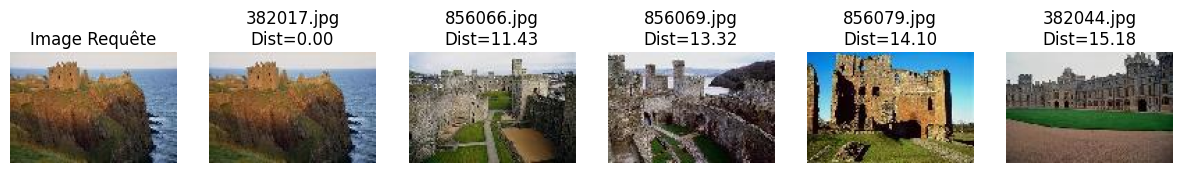

In [18]:
# Indexation et recherche
ind_Matrix, noms = CBIR_Indexation(path_base, fsize=6)
top_idx, top_dist = CBIR_Recherche(img_requete, ind_Matrix, noms, fsize=6)

plt.figure(figsize=(15,5))
plt.subplot(1,6,1)
plt.imshow(img_requete)
plt.title('Image Requête')
plt.axis('off')

for i, idx in enumerate(top_idx):
    plt.subplot(1,6,i+2)
    img = images_base[noms_base.index(noms[idx])]
    plt.imshow(img)
    plt.title(f'{noms[idx]}\nDist={top_dist[i]:.2f}')
    plt.axis('off')
plt.show()


### **Interprétation des résultats** (par couleur)
Les images retournées sont visuellement quasi proches (même type de scène et même couleurs dominantes), avec des différences mineures de variations d’éclairage et de contraste.


<h2>3.4	Recherche par Histogramme</h2>
"L’histogramme est souvent utilisé pour regrouper le nombre de pixels par intensité. L’histogramme peut être élaboré dans n’importe quel espace couleur : RGB, HSV, … et même en niveaux de gris. Des études ont montré que l’espace de couleur HSV est le plus adapté à ce type de système de recherche. L’histogramme est un vecteur dont la taille est égale au nombre de valeurs d’intensité dans l’image. Pour l’utiliser comme vecteur descripteur, l’idée est de quantifier l’histogramme en un nombre limité de caractéristiques afin de réduire la taille du descripteur.<br>
<br>
1. Modifier le code pour permettre d’avoir un système CBIR utilisant un vecteur descripteur composé des caractéristiques de couleur et d’histogramme. Il faut écrire une fonction « hsvHistogramFeatures » qui prend comme argument une image et qui retourne le vecteur descripteur créé à partir de l’histogramme. La fonction « getFeatures » doit être modifiée pour concaténer les deux vecteurs descripteurs de moments et d’histogramme.<br>
2. Relancer l'indexation avec en plus des moments de couleur, le descripteur à base d'histogramme. Lancer la recherche par le nouveau descripteur. Comparer les résultats de cette recherche avec la recherche utilisant seulement la caractéristique couleur.




In [21]:
def hsvHistogramFeatures(img, h_bins=8, s_bins=8, v_bins=8):
    """
    Calcule un histogramme HSV normalisé comme vecteur descripteur.
    h_bins, s_bins, v_bins : nombre de classes pour chaque composante HSV
    """
    img_hsv = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([img_hsv], [0,1,2], None, [h_bins, s_bins, v_bins],
                        [0,180, 0,256, 0,256])
    hist = cv2.normalize(hist, hist).flatten()  # normalisation et mise à plat
    return hist

def getFeatures(img, fsize=6):
    color_feats = color_Moments(img)
    hist_feats = hsvHistogramFeatures(img) # modifier afinde combiner moments + histogramme
    return np.concatenate((color_feats, hist_feats))

# Remarque: Indexation et recherche restent inchangées

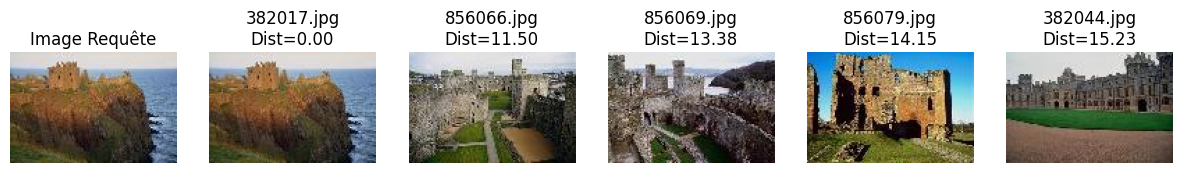

In [24]:
# Indexation et recherche avec descripteur combiné
ind_Matrix_hist, noms_hist = CBIR_Indexation(path_base, fsize=6)
top_idx_hist, top_dist_hist = CBIR_Recherche(img_requete, ind_Matrix_hist, noms_hist, fsize=6)

plt.figure(figsize=(15,5))
plt.subplot(1,6,1)
plt.imshow(img_requete)
plt.title('Image Requête')
plt.axis('off')

for i, idx in enumerate(top_idx_hist):
    plt.subplot(1,6,i+2)
    img = images_base[noms_base.index(noms_hist[idx])]
    plt.imshow(img)
    plt.title(f"{noms_hist[idx]}\nDist={top_dist_hist[i]:.2f}")
    plt.axis('off')
plt.show()


### **Interprétation des résultats** (par histogramme)
Les images retournées sont sont les mêmes mais les distances changent. Ceci peut etre explqué par le fait que notre dataset est limité à 270 img qui sont très similaires visuellement: la distance entre histogrammes reste très faible et similaire à celle des moments.

<h2>3.5	Recherche par texture</h2>
La texture est une information très importante et généralement toujours présente dans les images. Elle est largement utilisée dans les systèmes CBIR.<br>
<br>
1. Créer un nouveau descripteur de texture de taille 4 qui va contenir le contraste, la corrélation, l’énergie et l’homogénéité. Ces quatre informations sont très utilisées dans ce type de système et représentent des mesures statistiques extraites de la matrice de cooccurrence de niveau de gris (GLCM, Gray Level Co-occurrence Matrix), également appelée matrice de dépendance spatiale de niveau de gris. Les fonctions GLCM caractérisent la texture d'une image en calculant la fréquence à laquelle des paires de pixels avec des valeurs spécifiques et dans une relation spatiale spécifiée se produisent dans une image. Cela crée une matrice GLCM à partir de laquelle sont extraites des mesures statistiques. <br>
<br>
2. Modifier le code Python pour permettre d’avoir un système CBIR utilisant un vecteur descripteur composé de couleur, d’histogramme et de texture. Il faut également ajouter la fonction « textureFeatures » qui prend comme argument une image et qui retourne le vecteur descripteur créé à partir de la texture. Ensuite, la fonction « getFeatures » doit être modifiée pour concaténer les deux vecteurs descripteurs de moments et d’histogramme.<br>
<br>
3. Relancer l'indexation avec en plus des moments de couleur et le descripteur à base d'histogramme, le descripteur de texture. Lancer la recherche et comparer les résultats.

In [27]:
from skimage.feature import graycomatrix, graycoprops

def textureFeatures(img):
  """
  Calcule 4 caractéristiques de texture basées sur la GLCM : Contraste, Corrélation, Énergie et Homogénéité
  """
  # Conversion en niveaux de gris
  gray = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_RGB2GRAY)

  # Quantification (réduction du nombre de niveaux)
  gray = (gray / 4).astype(np.uint8)  # 64 niveaux

  # Matrice de cooccurrence pour une distance de 1 pixel dans 4 directions
  glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                      symmetric=True, normed=True)

  # Calcul des 4 propriétés statistiques moyennes
  contrast = graycoprops(glcm, 'contrast').mean()
  correlation = graycoprops(glcm, 'correlation').mean()
  energy = graycoprops(glcm, 'energy').mean()
  homogeneity = graycoprops(glcm, 'homogeneity').mean()

  return np.array([contrast, correlation, energy, homogeneity])

In [41]:
def getFeatures_combined(img, alpha, beta, gamma, fsize=6):
  """
  Combine les 3 types de descripteurs (moments, hsv , glcm) avec pondération ajustable
  """
  color_feats = color_Moments(img)
  color_feats = color_feats / np.linalg.norm(color_feats)

  hist_feats = hsvHistogramFeatures(img, h_bins=4, s_bins=4, v_bins=4)
  hist_feats = hist_feats / np.linalg.norm(hist_feats)

  text_feats = textureFeatures(img)
  text_feats = text_feats / np.linalg.norm(text_feats)

  return np.concatenate((alpha*color_feats, beta*hist_feats, gamma*text_feats))

def CBIR_Indexation_combined(path, alpha, beta, gamma, fsize=6):
  images, noms = lire_images(path)
  features = []
  for img in images:
      feat = getFeatures_combined(img, alpha, beta, gamma, fsize)
      features.append(feat)
  return np.array(features), noms

def CBIR_Recherche_combined(Imreq,ind_Matrix, noms, alpha, beta, gamma, fsize=6):
  feat_req = getFeatures_combined(Imreq, alpha, beta, gamma, fsize)
  distances = np.linalg.norm(ind_Matrix - feat_req, axis=1)
  idx_sorted = np.argsort(distances)
  return idx_sorted[:5], distances[idx_sorted[:5]]


===== Test 1 : α=0.6, β=0.3, γ=0.1 =====


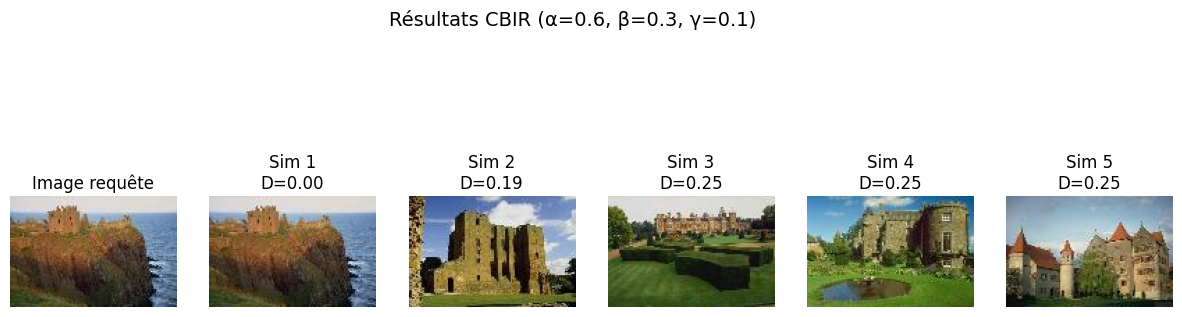


===== Test 2 : α=0.4, β=0.4, γ=0.2 =====


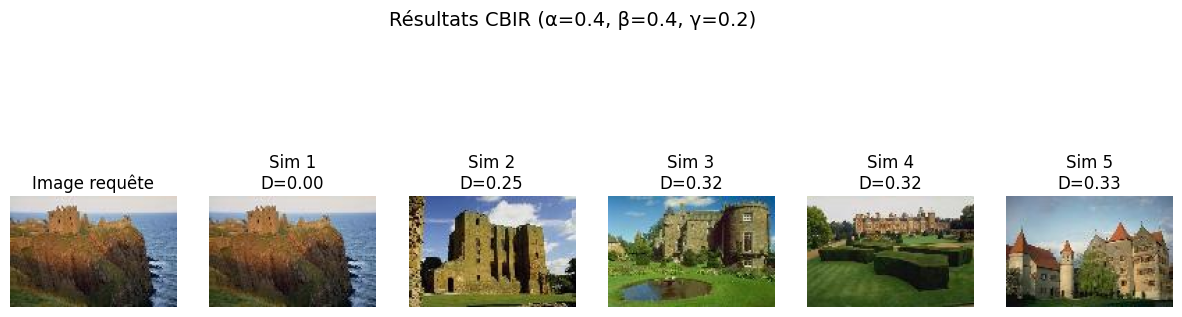


===== Test 3 : α=0.3, β=0.3, γ=0.4 =====


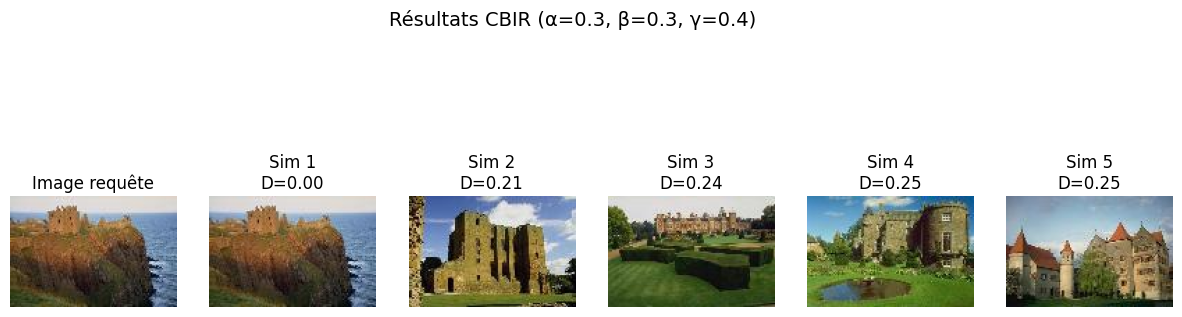

In [35]:
weight_sets = [
    (0.6, 0.3, 0.1),   # Couleur dominante
    (0.4, 0.4, 0.2),   # Poids équilibrés
    (0.3, 0.3, 0.4)    # Texture dominante
]

for i, (alpha, beta, gamma) in enumerate(weight_sets, start=1):
    print(f"\n===== Test {i} : α={alpha}, β={beta}, γ={gamma} =====")
    ind_Matrix, noms = CBIR_Indexation_combined(path_base, alpha, beta, gamma, fsize=6)
    top_idx, top_dist = CBIR_Recherche_combined(img_requete, ind_Matrix, noms, alpha, beta, gamma)

    plt.figure(figsize=(15,5))
    plt.suptitle(f"Résultats CBIR (α={alpha}, β={beta}, γ={gamma})", fontsize=14)

    plt.subplot(1,6,1)
    plt.imshow(img_requete)
    plt.title("Image requête")
    plt.axis('off')

    for j, idx in enumerate(top_idx):
        img = cv2.imread(os.path.join(path_base, noms[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,6,j+2)
        plt.imshow(img)
        plt.title(f"Sim {j+1}\nD={top_dist[j]:.2f}")
        plt.axis('off')

    plt.show()

### **Interprétation des résultats**
Le dataset utilisé étant assez limité et contenant des images visuellement très similaires, les variations des poids α, β et γ (couleur, histogramme, texture) n’ont pas entraîné de changements significatifs dans les résultats.
Les mêmes images apparaissent généralement dans le top 5, parfois dans un ordre différent.
Cela s’explique par le fait que les **descripteurs extraits sont globaux** et que les différences visuelles entre les images sont **faibles à l’échelle du dataset**.

<h2>3.6 Recherche par forme</h2>
La forme est un attribut fondamental pour décrire les objets dans une image. Elle permet de distinguer des objets même si leur couleur ou texture diffère. <br><br>
1. Créer un nouveau descripteur de forme en utlisant l'Histogramme des Orientations des Gradients (HOG). HOG capture la distribution des orientations locales des gradients sur toute l'image, ce qui permet de représenter à la fois les structures globales et les détails locaux de l'objet.<br>
Les étapes à suivre sont: <br>
   - Convertir l'image en niveaux de gris.<br>  
   - Découper l'image en blocs (par ex. 8×8 pixels). <br>
   - Calculer pour chaque bloc un histogramme des orientations (ex. 8  orientations).  <br>
   - Normaliser les blocs pour plus de robustesse.  <br>
   - Concaténer tous les histogrammes pour obtenir le vecteur final de caractéristiques.  <br>
<br>
2. Ajouter une fonction Python  « shapeFeaturesHOG » qui retourne le vecteur HOG à partir d'une image. <br>
<br>
3. Modifier la fonction  « getFeatures » pour concaténer le vecteur HOG avec les descripteurs existants de couleur, histogramme et texture<br>
<br>
4. Relancer l’indexation et la recherche CBIR avec ce nouveau vecteur complet.  
   Comparez les résultats avec et sans le descripteur HOG pour observer l’amélioration de la recherche basée sur la forme des objets, pour les deux imags requêtes.



In [42]:
from skimage.feature import hog

def shapeFeaturesHOG(img):
  """
  Calcule le descripteur HOG (Histogram of Oriented Gradients)
  """
  gray = cv2.cvtColor(cv2.resize(img, (128, 128)), cv2.COLOR_RGB2GRAY)

  # Calcul du HOG
  hog_features = hog(
      gray,
      orientations=9,       # Nombre d’orientations (bins)
      pixels_per_cell=(8,8),
      cells_per_block=(2,2),
      block_norm='L2-Hys',
      transform_sqrt=True,
      feature_vector=True
  )

  hog_features = hog_features / np.linalg.norm(hog_features) if np.linalg.norm(hog_features) != 0 else hog_features
  return hog_features

def getFeatures_final(img, alpha=0.4, beta=0.3, gamma=0.2, delta=0.1, fsize=6):
    """
    Combine tous les descripteurs vus avec pondération ajustable
    """
    color_feats = color_Moments(img)
    color_feats = color_feats / np.linalg.norm(color_feats)

    hist_feats = hsvHistogramFeatures(img, h_bins=4, s_bins=4, v_bins=4)
    hist_feats = hist_feats / np.linalg.norm(hist_feats)

    text_feats = textureFeatures(img)
    text_feats = text_feats / np.linalg.norm(text_feats)

    shape_feats = shapeFeaturesHOG(img)
    shape_feats = shape_feats / np.linalg.norm(shape_feats)

    combined = np.concatenate((
        alpha * color_feats,
        beta * hist_feats,
        gamma * text_feats,
        delta * shape_feats
    ))
    return combined

def CBIR_Indexation_final(path, alpha, beta, gamma, delta, fsize=6):
  images, noms = lire_images(path)
  features = []
  for img in images:
      feat = getFeatures_final(img, alpha, beta, gamma, delta, fsize)
      features.append(feat)
  return np.array(features), noms

def CBIR_Recherche_final(Imreq,ind_Matrix, noms, alpha, beta, gamma, delta, fsize=6):
  feat_req = getFeatures_final(Imreq, alpha, beta, gamma, delta, fsize)
  distances = np.linalg.norm(ind_Matrix - feat_req, axis=1)
  idx_sorted = np.argsort(distances)
  return idx_sorted[:5], distances[idx_sorted[:5]]



===== Test 1 : α=0.4, β=0.3, γ=0.2, d=0.1 =====


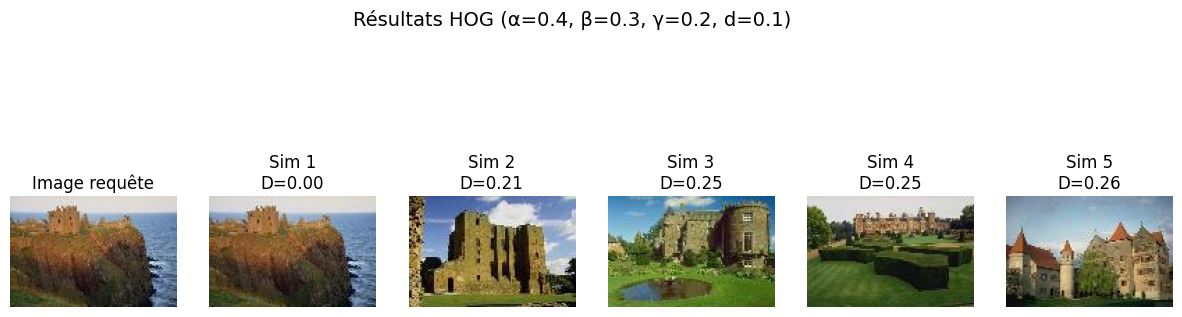


===== Test 2 : α=0.25, β=0.25, γ=0.25, d=0.25 =====


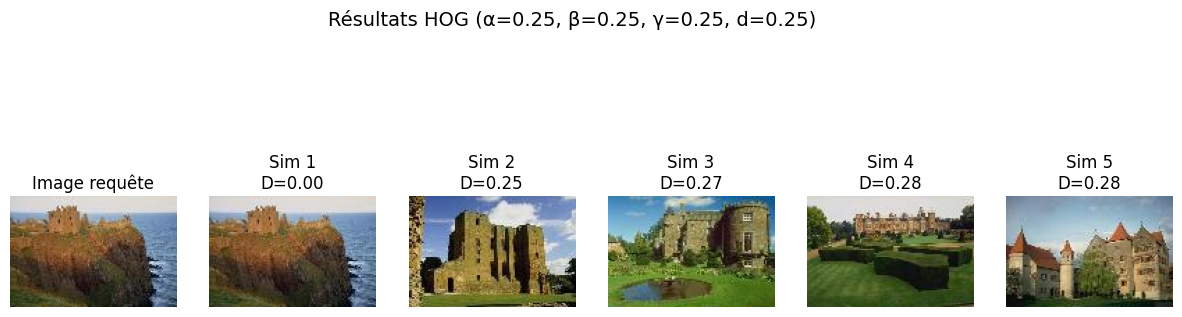


===== Test 3 : α=0.1, β=0.1, γ=0.4, d=0.4 =====


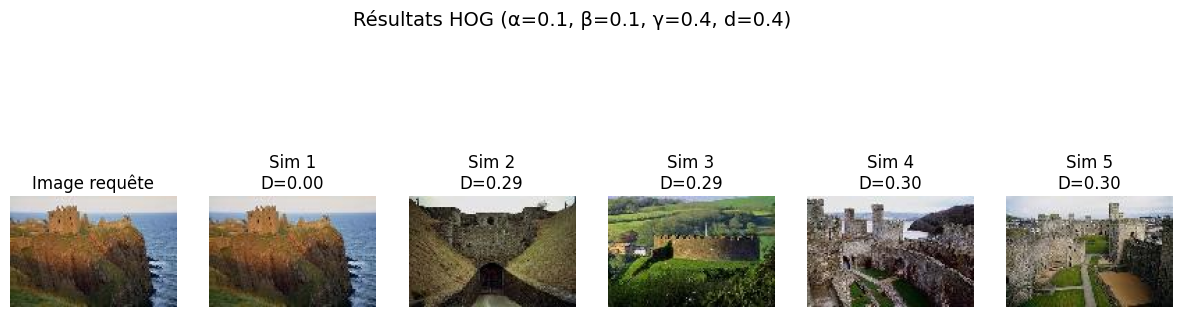


===== Test 4 : α=0.1, β=0.1, γ=0.1, d=0.6 =====


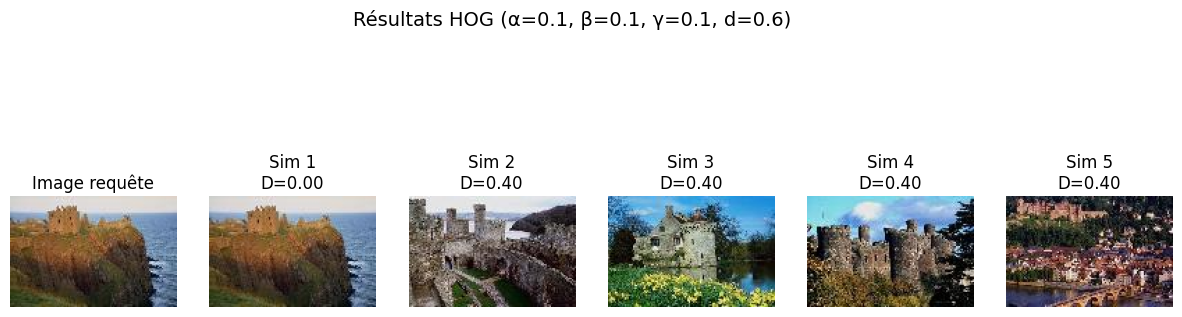

In [46]:
# incrémenter delta petit à petit
weight_sets = [
    (0.4, 0.3, 0.2, 0.1),
    (0.25, 0.25, 0.25, 0.25),
    (0.1, 0.1, 0.4, 0.4),
    (0.1, 0.1, 0.1, 0.6)
]

for i, (alpha, beta, gamma, delta) in enumerate(weight_sets, start=1):
    print(f"\n===== Test {i} : α={alpha}, β={beta}, γ={gamma}, d={delta} =====")
    ind_Matrix, noms = CBIR_Indexation_final(path_base, alpha, beta, gamma, delta, fsize=6)
    top_idx, top_dist = CBIR_Recherche_final(img_requete, ind_Matrix, noms, alpha, beta, gamma, delta)

    plt.figure(figsize=(15,5))
    plt.suptitle(f"Résultats HOG (α={alpha}, β={beta}, γ={gamma}, d={delta})", fontsize=14)

    plt.subplot(1,6,1)
    plt.imshow(img_requete)
    plt.title("Image requête")
    plt.axis('off')

    for j, idx in enumerate(top_idx):
        img = cv2.imread(os.path.join(path_base, noms[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,6,j+2)
        plt.imshow(img)
        plt.title(f"Sim {j+1}\nD={top_dist[j]:.2f}")
        plt.axis('off')

    plt.show()

### **Interprétation des résultats**
Pour un ensemble de poids équilibrés, les résultats montrent une meilleure distinction entre des objets de formes différentes mais de couleur similaire.
En augmentant progressivement le poids du descripteur HOG, le système privilégie de plus en plus la similarité de forme (structure/contour des objets similaire). Sur ce dataset limité, certaines images restent communes au top 5, mais leur ordre et leur pertinence visuelle changent selon le poids delta.

### 3.7	Robustesse vis-à-vis des transformations géométriques
La robustesse des systèmes CBIR est testée en présence des transformations géométriques ; à savoir la **translation**, la **rotation** et le **changement d’échelle**.
 Appliquer quelques transformations géométriques aux images requêtes et relancer la recherche. Interpréter les résultat de recherche.

In [48]:
def transform_image(img, translation=(0,0), rotation=0, scale=1.0):
  """
  img: image RGB
  translation: (tx, ty)
  rotation: angle en degrés
  scale: facteur d'échelle
  """
  h, w = img.shape[:2]
  M = cv2.getRotationMatrix2D((w//2, h//2), rotation, scale)
  M[:,2] += np.array(translation)
  transformed = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
  return transformed

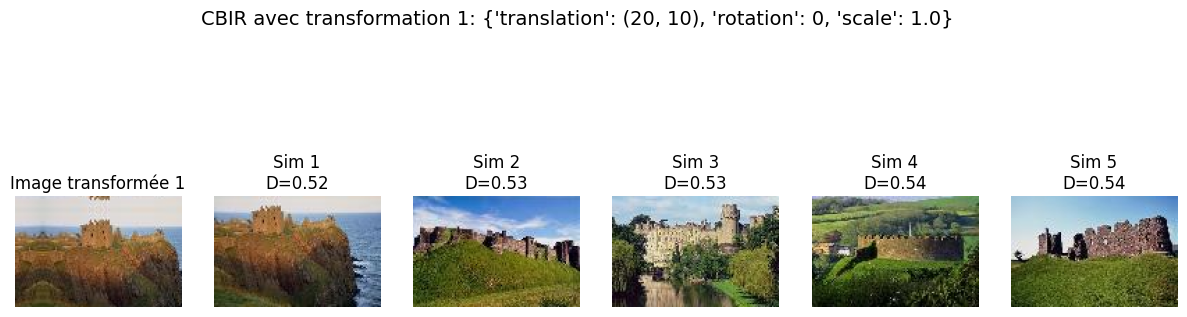

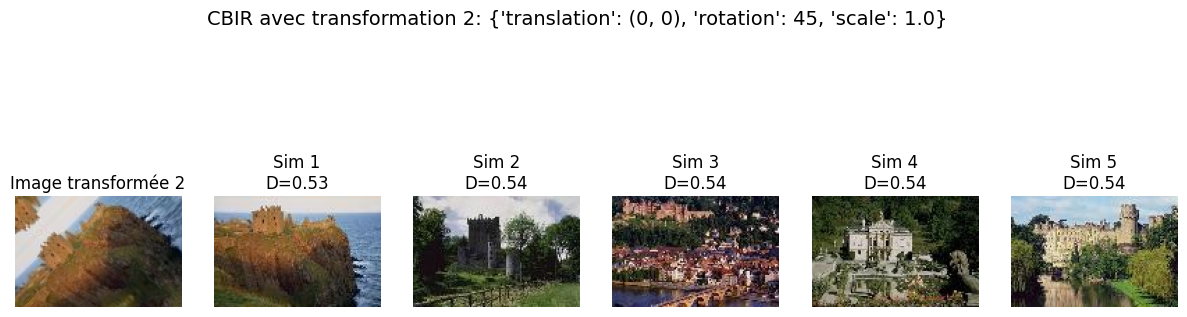

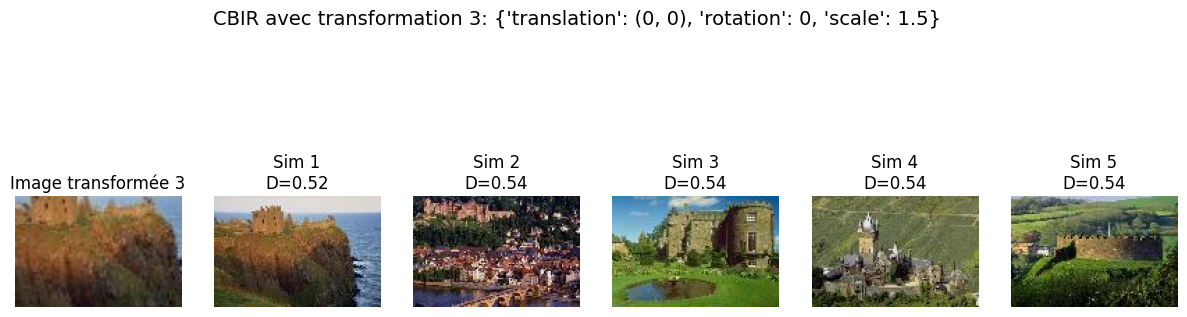

In [52]:
# Liste des transformations à tester
transformations = [
    {'translation': (20, 10), 'rotation': 0, 'scale': 1.0},   # translation
    {'translation': (0,0), 'rotation': 45, 'scale': 1.0},     # rotation 45°
    {'translation': (0,0), 'rotation': 0, 'scale': 1.5}       # zoom 150%
]

for i, t in enumerate(transformations, start=1):
    img_trans = transform_image(img_requete, t['translation'], t['rotation'], t['scale'])

    top_idx, top_dist = CBIR_Recherche_final(img_trans, ind_Matrix, noms, alpha=0.25, beta=0.25, gamma=0.25, delta=0.25)

    # Affichage
    plt.figure(figsize=(15,5))
    plt.subplot(1,6,1)
    plt.imshow(img_trans)
    plt.title(f"Image transformée {i}")
    plt.axis('off')

    for j, idx in enumerate(top_idx):
        img_top = cv2.imread(os.path.join(path_base, noms[idx]))
        img_top = cv2.cvtColor(img_top, cv2.COLOR_BGR2RGB)
        plt.subplot(1,6,j+2)
        plt.imshow(img_top)
        plt.title(f"Sim {j+1}\nD={top_dist[j]:.2f}")
        plt.axis('off')

    plt.suptitle(f"CBIR avec transformation {i}: {t}", fontsize=14)
    plt.show()

### **Interprétation des résultats**
Les résultats montrent que le système est robuste aux translations et aux petits changements d’échelle, mais que les rotations importantes perturbent la recherche.
Cela s’explique par la sensibilité des descripteurs HOG et GLCM à l’orientation.